In [ ]:
### Andrew Dant & Alicia Hernandez
### AI 570
### Professor Wang
### Chest X-Ray Project

#Libraries and stuff
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import torch
from torch import nn
from torch.nn import functional as F
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
import torch.optim  as optim
import matplotlib.pyplot as plt
import os

#Upload the CSV file
path = r"C:\Users\andrew.dant\Downloads\archive"
os.chdir(path)
patients = pd.read_csv("Data_Entry_2017.csv")

#Data Exploration
print(patients.head())
print(patients.columns)
print(patients.describe())
print(patients.shape)  #(112120, 12)
print(patients.dtypes)     #object, int64, float64


        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN 

In [6]:
# TODO encode ordinal variables like gender and view position, remove variables like id and original image width from x
print(patients['View Position'].unique())
print(patients['Patient Gender'].unique())

['PA' 'AP']
['M' 'F']


In [3]:

# Clean column names
patients.columns = (
    patients.columns
    .str.lower()               # Convert to lowercase
    .str.replace(' ', '_')     # Replace spaces with underscores
    .str.replace(r'[^a-zA-Z0-9_]', '', regex=True)  # Remove special characters
    .str.strip()               # Strip whitespace
)

print("Cleaned column names:")
print(patients.columns)


Cleaned column names:
Index(['image_index', 'finding_labels', 'followup_', 'patient_id',
       'patient_age', 'patient_gender', 'view_position', 'originalimagewidth',
       'height', 'originalimagepixelspacingx', 'y', 'unnamed_11'],
      dtype='object')


In [4]:

patients.drop('unnamed_11', axis=1, inplace=True)

# determine the set of unique interests
finding_set = set()
for finding_list in patients['finding_labels'].tolist():
    for finding in finding_list.split('|'):
        finding_set.add(finding)
        
print(f'Unique diagnoses in "finding_labels": {sorted(finding_set)}')

# build the columns and rows of the dummy variables
dummy_finding_variables = []
for finding_list in patients['finding_labels'].tolist():
    dummy_finding_variables.append([1 if finding in finding_list.split('|') else 0 for finding in finding_set])

dummy_finding_variables = pd.DataFrame(dummy_finding_variables, columns=[finding for finding in finding_set])

# replace the old finding labels column with the dummy variables
patients.drop('finding_labels', axis=1, inplace=True)
patients = patients.join(dummy_finding_variables)
patients.dtypes

print(patients.iloc[:, -15:])


Unique diagnoses in "finding_labels": ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
        Consolidation  Pneumonia  Edema  Infiltration  Fibrosis  Pneumothorax  \
0                   0          0      0             0         0             0   
1                   0          0      0             0         0             0   
2                   0          0      0             0         0             0   
3                   0          0      0             0         0             0   
4                   0          0      0             0         0             0   
...               ...        ...    ...           ...       ...           ...   
112115              0          1      0             0         0             0   
112116              0          0      0             0         0             0   
112117              0        

In [8]:

#Remove NA's
patients.isnull()   #Find missing values in data set
patients = patients.dropna()    #Drop Null values and update df

patients.describe()


,followup_,patient_id,patient_age,originalimagewidth,height,originalimagepixelspacingx,y,Consolidation,Pneumonia,Edema,...,Pneumothorax,No Finding,Effusion,Mass,Emphysema,Atelectasis,Pleural_Thickening,Cardiomegaly,Hernia,Nodule
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,0.041625,0.012763,0.020540,...,0.047289,0.538361,0.118775,0.051570,0.022440,0.103095,0.030191,0.024759,0.002025,0.056466
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,0.199732,0.112251,0.141841,...,0.212256,0.498529,0.323524,0.221158,0.148111,0.304084,0.171113,0.155391,0.044950,0.230821
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:

#Find duplicate values
patients.duplicated().sum()     #No duplicates


0

In [6]:

#Correlation
# columns with a numeric datatype, other than the new dummy variables for encoding classes
numeric_patients = patients.iloc[:, : -15].select_dtypes(include=[np.number])
if not numeric_patients.empty:
    print(numeric_patients.corr())
else:
    print("No numeric columns to compute correlation.")     #No numeric columns to compute correlation.


                            followup_  patient_id  patient_age  \
followup_                    1.000000   -0.026528    -0.028684   
patient_id                  -0.026528    1.000000    -0.041084   
patient_age                 -0.028684   -0.041084     1.000000   
originalimagewidth           0.039551    0.222263     0.087670   
height                      -0.127636    0.193855     0.016914   
originalimagepixelspacingx   0.017533   -0.218915     0.002522   
y                            0.017533   -0.218915     0.002522   

                            originalimagewidth    height  \
followup_                             0.039551 -0.127636   
patient_id                            0.222263  0.193855   
patient_age                           0.087670  0.016914   
originalimagewidth                    1.000000  0.587006   
height                                0.587006  1.000000   
originalimagepixelspacingx           -0.832195 -0.797572   
y                                    -0.832195 -0.7

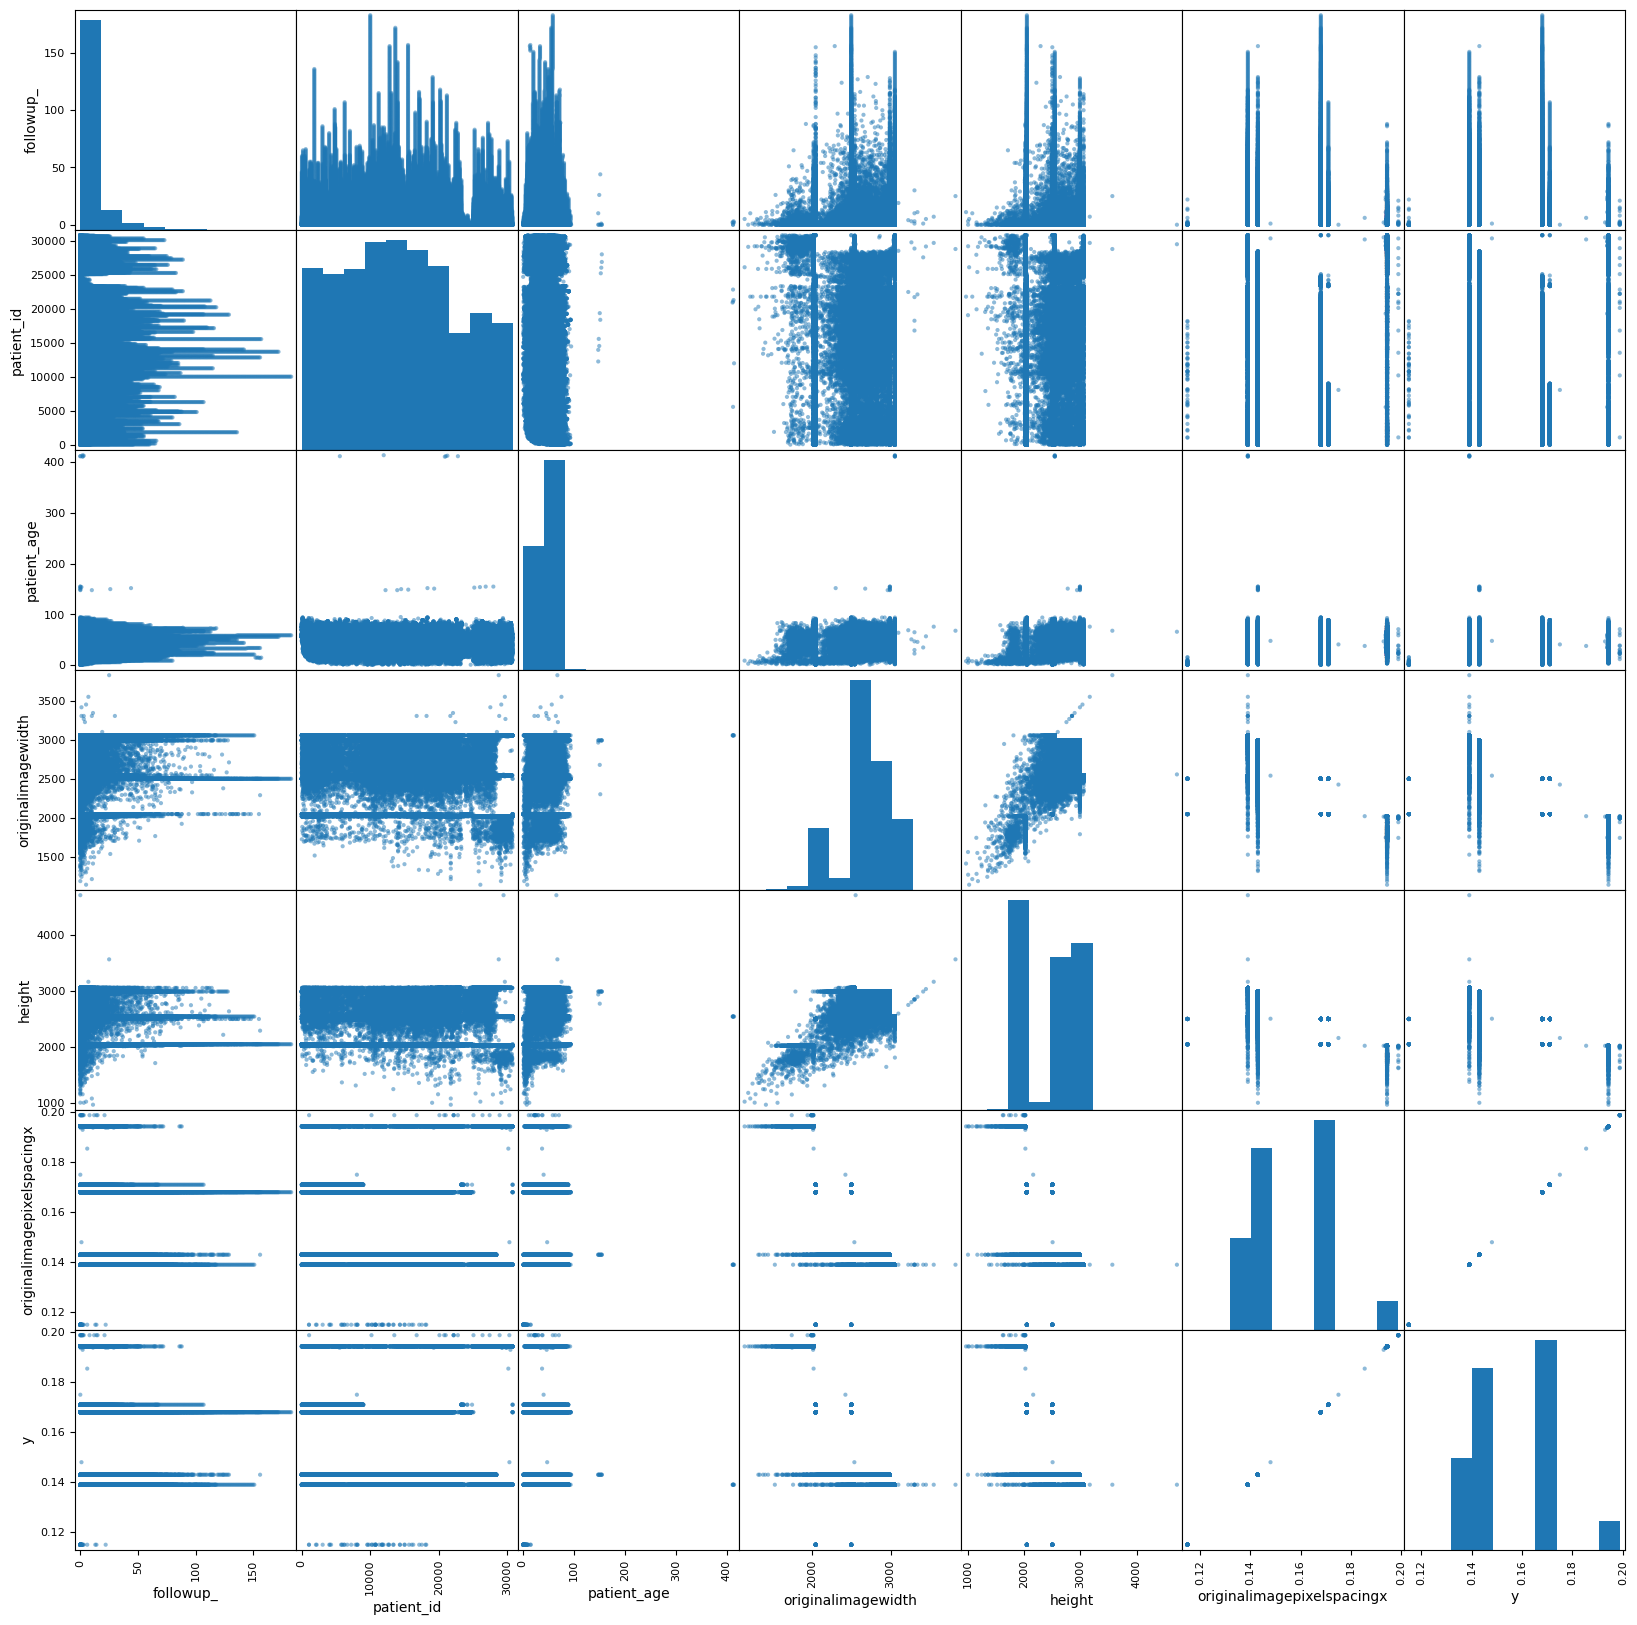

In [7]:

#Scatterplot matrix
if not numeric_patients.empty and not numeric_patients.isnull().all(axis=0).any():
    pd.plotting.scatter_matrix(numeric_patients, figsize=(20, 20))
    plt.show()
else:
    print("No valid numeric data available for scatter matrix.")    #No valid numeric data available for scatter matrix.


In [7]:

#Scale the data
scaler = MinMaxScaler()

numeric_patients = patients.select_dtypes(include=[np.number])
if not numeric_patients.empty:
    print("Numeric columns available for scaling:")
    print(numeric_patients.columns)
    # Scale the data
    scaler = MinMaxScaler()
    x = scaler.fit_transform(numeric_patients)  # Scale only numeric data
else:
    print("No numeric columns available for scaling.")


Numeric columns available for scaling:
Index(['followup_', 'patient_id', 'patient_age', 'originalimagewidth',
       'height', 'originalimagepixelspacingx', 'y', 'Consolidation',
       'Effusion', 'Edema', 'Fibrosis', 'Pneumonia', 'Nodule', 'Atelectasis',
       'Cardiomegaly', 'Pneumothorax', 'Hernia', 'No Finding', 'Infiltration',
       'Emphysema', 'Mass', 'Pleural_Thickening'],
      dtype='object')


In [9]:
patients

,image_index,followup_,patient_id,patient_age,patient_gender,view_position,originalimagewidth,height,originalimagepixelspacingx,y,...,Nodule,Atelectasis,Cardiomegaly,Pneumothorax,Hernia,No Finding,Infiltration,Emphysema,Mass,Pleural_Thickening
0,00000001_000.png,0,1,58,M,PA,2682,2749,0.143,0.143,...,0,0,1,0,0,0,0,0,0,0
1,00000001_001.png,1,1,58,M,PA,2894,2729,0.143,0.143,...,0,0,1,0,0,0,0,1,0,0
2,00000001_002.png,2,1,58,M,PA,2500,2048,0.168,0.168,...,0,0,1,0,0,0,0,0,0,0
3,00000002_000.png,0,2,81,M,PA,2500,2048,0.171,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,0,3,81,F,PA,2582,2991,0.143,0.143,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,1,30801,39,M,PA,2048,2500,0.168,0.168,...,0,0,0,0,0,0,0,0,1,0
112116,00030802_000.png,0,30802,29,M,PA,2048,2500,0.168,0.168,...,0,0,0,0,0,1,0,0,0,0
112117,00030803_000.png,0,30803,42,F,PA,2048,2500,0.168,0.168,...,0,0,0,0,0,1,0,0,0,0
112118,00030804_000.png,0,30804,30,F,PA,2048,2500,0.168,0.168,...,0,0,0,0,0,1,0,0,0,0


In [11]:

#begin merging the dataset 

# Filter the DataFrame for existing images
patients_with_images = patients[patients['image_index'].isin(os.listdir(path))]

patients_with_images


,image_index,followup_,patient_id,patient_age,patient_gender,view_position,originalimagewidth,height,originalimagepixelspacingx,y,...,Nodule,Atelectasis,Cardiomegaly,Pneumothorax,Hernia,No Finding,Infiltration,Emphysema,Mass,Pleural_Thickening


In [ ]:

# Split into training and testing sets (70:30)
train_df, test_df = train_test_split(patients_with_images, test_size=0.3, random_state=42)

# Data augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col='image_file_name',
    y_col='finding_labels',
    target_size=(150, 150),
    batch_size=100,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path,
    x_col='image_file_name',
    y_col='finding_labels',
    target_size=(150, 150),
    batch_size=100,
    class_mode='categorical',
    shuffle=False  # Keep the order for testing
)


In [ ]:

#Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, validation_data=test_generator, epochs=20)

# Get features from the second-to-last layer
feature_extractor = Sequential(model.layers[:-1])  # Exclude the last layer
features = feature_extractor.predict(train_generator)

# Perform K-means clustering
n_clusters = 10  # Adjust based on your needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(features)

# Add clustering results to your training DataFrame
train_df['cluster'] = kmeans.labels_

print("Clustering results added to training DataFrame:")
print(train_df[['image_file_name', 'finding_labels', 'cluster']].head())


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Train the model and save the history
history = model.fit(train_generator, validation_data=test_generator, epochs=20)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions on the test set
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes

# Generate a classification report
print(classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


